In [1]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
import import_ipynb
import torch
import cv2
import numpy as np
from matplotlib import cm
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from CustomDataset import ControlsDataset
from torchvision import models
from tqdm.notebook import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device', device)
torch.cuda.empty_cache()

importing Jupyter notebook from CustomDataset.ipynb
using device cuda


In [2]:
dataset = ControlsDataset(stack_size = 3,       #each stack contains this many images
                          stride = 30,          #each image in the stack is seperated by this many frames
                          batch_size = 16,      #15 random stacks
                          size = 0,             #0 is entire dataset, anything else is a cutoff
                          img_folder = '../../data/cropped/', 
                          csv_path = '../../data/cropped/data.csv')
print("Data size", len(dataset))

imgs = dataset[0]['image']

Total training stacks 411
Total validation stacks 274
Data size 10959


In [3]:
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

In [8]:
def decode_segmap(image, nc=21):
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = colors[l, 0]
        g[idx] = colors[l, 1]
        b[idx] = colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [25]:
def segment(net, img):
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0)
    out = net(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.imshow(img, interpolation='bicubic')
    plt.imshow(rgb, alpha=0.3)
    plt.axis('off')
    plt.show()

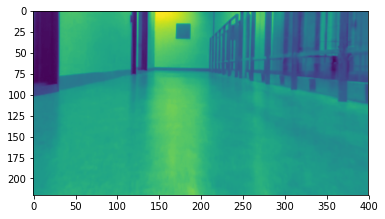

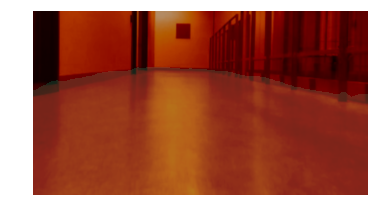

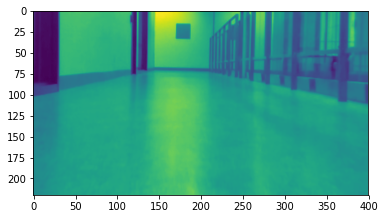

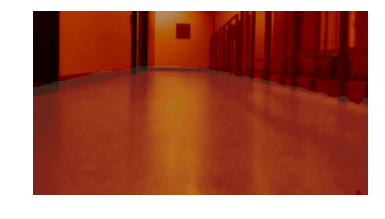

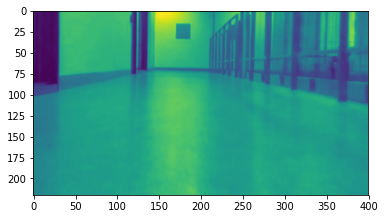

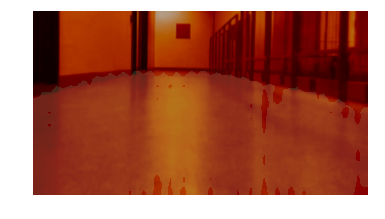

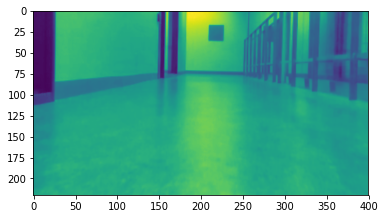

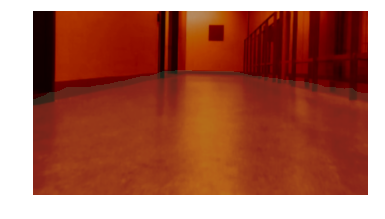

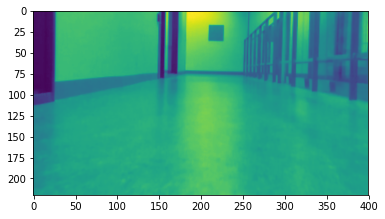

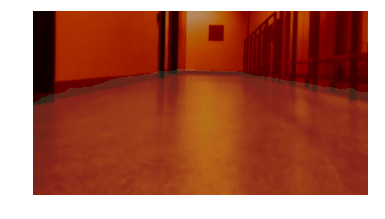

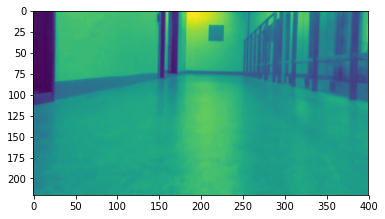

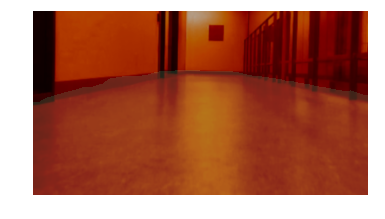

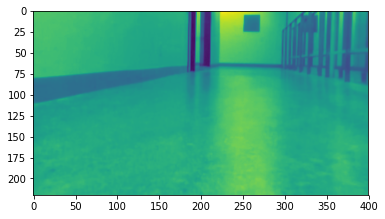

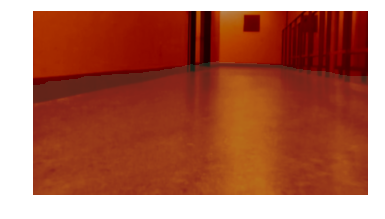

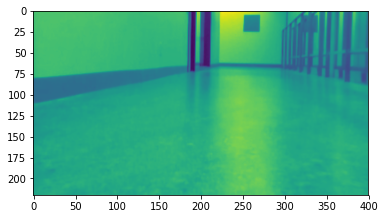

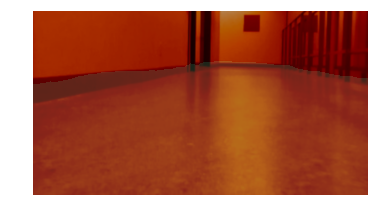

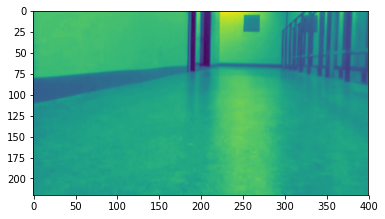

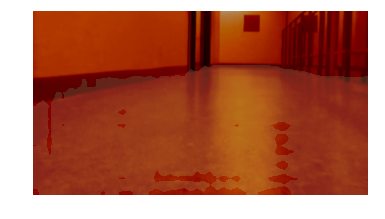

In [30]:
for i in range(9):
    img = Image.fromarray(np.uint8(cm.gist_heat(imgs[i])*255))
    img = img.convert("RGB")
    segment(fcn, img)